## Download data

In [ ]:
# !wget -O ../data/geotiff.zip 'https://dl.dropbox.com/scl/fo/yhjzz9lz1zynw2abcy5k6/h/geotiff.zip?dl=1&rlkey=wz5gosnhfz83tkmmg540puiqa'

In [75]:
import os
from glob import glob
import rasterio
from PIL import Image
import numpy as np
from rasterio.features import geometry_mask
from rasterio.transform import Affine
from shapely.geometry import box
from fiona.crs import from_epsg
import geopandas as gpd
import folium
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame, GeoSeries


In [4]:
def read_prj_file(prj_file_path):
    with open(prj_file_path, 'r') as prj_file:
        prj_contents = prj_file.read()
    return prj_contents

def search_files(file_path, pattern="*"):
    return glob(os.path.join(file_path, pattern))

def read_tfw(filename):
    with open(filename, 'r') as f:
        return [float(line.strip()) for line in f]

# 1. TIFF image processing

## 1.1 Read TIFF image and its metadata from TFW file

In [9]:
geotiff_root_path = "../data/geotiff/geotiff"

tiff_imgs = search_files(geotiff_root_path, "*.tif")
tfw_data = [ read_tfw(image_path.replace(".tif", ".tfw")) for image_path in tiff_imgs]

In [12]:
tiff_imgs[0], tfw_data[0]

('../data/geotiff/geotiff\\JS_0124_P1_B1_0002.tif',
 [0.05, 0.0, 0.0, -0.05, 317064.318, 408800.525])

## 1.2 Inspect TIFF image

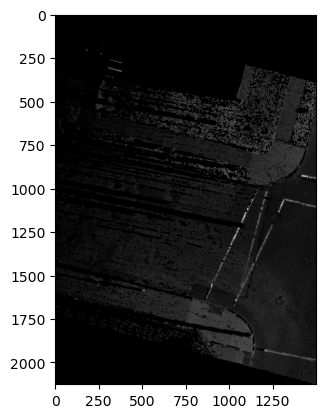

In [23]:
plt.imshow(np.array(Image.open(tiff_imgs[0])))

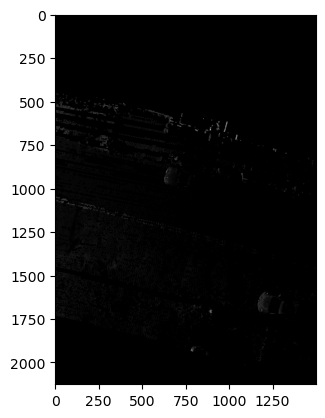

In [44]:
plt.imshow(np.array(Image.open(tiff_imgs[2])))

In [15]:
sample_dataset = rasterio.open(tiff_imgs[0])

### 1.2.1 The transformation information is the same as the one in the TFW file

In [16]:
sample_dataset.transform

Affine(0.05, 0.0, 317064.293,
       0.0, -0.05, 408800.55)

### 1.2.2 Convert the CRS to EPSG:4326

Based on the export configuration, the CRS of the TIFF image is EPSG:6527.

In [45]:
# Define the source and target CRS
crs_4326 = 'EPSG:4326'
crs_nj = CRS.from_string('EPSG:6527')

# Create a transformer for the conversion from target to source CRS
transformer_nj_to_4326 = Transformer.from_crs(crs_nj, crs_4326, always_xy=True)

# Example conversion from EPSG:6527 to EPSG:4326
x, y = (317064.293, 408800.55)  # Example UTM coordinates in New Jersey
lon, lat = transformer_nj_to_4326.transform(x, y)
print(f'Converted from UTM to EPSG:4326: ({lon}, {lat})')





Converted from UTM to EPSG:4326: (-75.12449518092915, 39.95407717768508)


# Sidewalks shapefile processing

In [26]:
shapefile_path = "../data/DVRPC_Pedestrian_Network_-_Sidewalks/DVRPC_Pedestrian_Network_-_Sidewalks.shp"

sidewalk_gdf = gpd.read_file(shapefile_path)

In [27]:
sidewalk_gdf_nj = sidewalk_gdf.to_crs(crs_nj)

In [28]:
sidewalk_gdf_nj.head()

,objectid,line_type,material,material_o,feat_type,raised,width,captured,state,county,muni,community,ped_sig,globalid,created_us,created_da,last_edite,last_edi_1,Shape__Len,geometry
0,2,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,PA,MONTGOMERY,42 091 275,NaN,NaN,c5dc4cc9-754d-4ca1-a6d0-a496cb090c0d,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,47.111359,"LINESTRING (216609.350 487423.518, 216624.844 ..."
1,3,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,PA,MONTGOMERY,42 091 275,NaN,NaN,f23b94bc-2559-4954-a250-ebe20885c380,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,7.089109,"LINESTRING (216502.459 487409.531, 216498.619 ..."
2,4,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,PA,MONTGOMERY,42 091 080,NaN,NaN,201464fb-86d1-4859-9ba2-d05f6279bccc,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,32.771410,"LINESTRING (312851.431 486867.835, 312829.113 ..."
3,5,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,PA,MONTGOMERY,42 091 080,NaN,NaN,9a5c5aca-5e2b-4bab-b7da-5827d071e597,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,371.430116,"LINESTRING (308091.750 486178.083, 308141.342 ..."
4,6,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,PA,MONTGOMERY,42 091 265,NaN,NaN,cb9d5ab8-5ff1-468d-abe8-af3d6d47530a,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,151.519159,"LINESTRING (327659.529 486803.033, 327657.659 ..."


In [65]:
sample_bounds = sample_dataset.bounds
sample_bounds_gdf = gpd.GeoDataFrame(geometry=[box(*sample_bounds)], crs=crs_nj)

sample_bounds_gdf.centroid[0].coords[0]

(317101.793, 408747.4)

In [30]:
sidewalks_in_image = gpd.sjoin(sidewalk_gdf_nj, sample_bounds_gdf, how="inner", predicate='intersects')
sidewalks_in_image

,objectid,line_type,material,material_o,feat_type,raised,width,captured,state,county,...,community,ped_sig,globalid,created_us,created_da,last_edite,last_edi_1,Shape__Len,geometry,index_right
213382,294098,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,NJ,NaN,...,NaN,NaN,5a4963a9-1283-4bd5-b4c4-ca1875c86f7b,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,37.758477,"LINESTRING (317119.611 408710.121, 317096.669 ...",0
235747,330791,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,NJ,NaN,...,NaN,NaN,170e74ad-c3ed-4ea5-b804-f789d84a2405,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,96.250549,"LINESTRING (316892.329 408782.214, 316900.929 ...",0
258336,367749,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,NJ,NaN,...,NaN,NaN,206c24d2-62d5-48ec-bd2d-ca5d4134870a,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,132.918247,"LINESTRING (317214.627 409076.606, 317206.709 ...",0
280816,404456,1,CONCRETE,NaN,PATH,N/A,NaN,AERIAL,NJ,NaN,...,NaN,NaN,3df7cd71-3b15-4c5a-b94e-86cc42e108d4,slawrence_dvrpcgis,2021-04-27,slawrence_dvrpcgis,2021-04-27,80.156275,"LINESTRING (316933.323 408805.846, 317128.601 ...",0


In [110]:
def get_dataset(tiff_image_path):
    return rasterio.open(tiff_image_path)

def get_intersection(tiff_dataset, sidewalk_gdf_nj, source_crs=CRS.from_string('EPSG:6527'), target_crs=CRS.from_string('EPSG:4326')):
    tiff_bounds = tiff_dataset.bounds
    tiff_bounds_gdf = gpd.GeoDataFrame(geometry=[box(*tiff_bounds)], crs=source_crs)
    sidewalks_in_image = gpd.sjoin(sidewalk_gdf_nj, tiff_bounds_gdf, how="inner", predicate='intersects')
    return sidewalks_in_image


def plot_interactive_map(intersection_gdf:GeoDataFrame, tiff_dataset, source_crs=CRS.from_string('EPSG:6527'), target_crs='EPSG:4326'):
    tiff_bounds = tiff_dataset.bounds
    tiff_bounds_gdf = gpd.GeoDataFrame(geometry=[box(*tiff_bounds)], crs=source_crs)
    centroid = tiff_bounds_gdf.centroid.to_crs(target_crs)[0].coords[0]
    tiff_bounds_gdf_4326 = tiff_bounds_gdf.to_crs(target_crs)
    intersection_gdf_4326 = intersection_gdf.to_crs(target_crs)
    m = folium.Map(location=[centroid[1], centroid[0]], zoom_start=18, tiles='cartodbpositron')
    folium.GeoJson(intersection_gdf_4326).add_to(m)

    green_style1 = {'fillColor': '#228B22', 'color': '#228B22'}
    folium.GeoJson(tiff_bounds_gdf_4326, style_function=lambda x:green_style1).add_to(m)
    return m

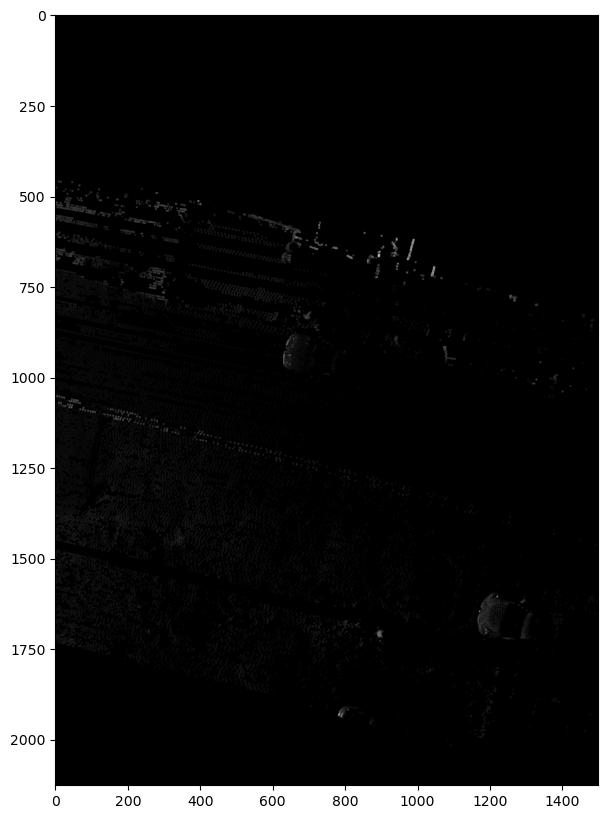

In [125]:
file_number = 2
plt.figure(figsize=(10,10))
plt.imshow(np.array(Image.open(tiff_imgs[file_number])))

In [126]:
dataset = get_dataset(tiff_imgs[file_number])
intersection_gdf = get_intersection(dataset, sidewalk_gdf_nj)
print(f"Number of sidewalks in image: {len(intersection_gdf)}")
plot_interactive_map(intersection_gdf, dataset)

Number of sidewalks in image: 2


In [54]:
test = sidewalks_in_image['geometry'].centroid.iloc[0]
# test.coords[0], test.coords[1]
print(test.coords[0])

(317108.14013963693, 408664.16529227805)


In [ ]:
# Example conversion from UTM to EPSG:4326
x, y = (317064.293, 408800.55)  # Example UTM coordinates in New Jersey
lon, lat = transformer_nj_to_4326.transform(x, y)
print(f'Converted from UTM to EPSG:4326: ({lon}, {lat})')

In [42]:
import folium
sidewalks_in_image_wgs84 = sidewalks_in_image.to_crs(crs_4326)
sample_bounds_gdf_wgs84 = sample_bounds_gdf.to_crs(crs_4326)
m = folium.Map(location=[39.95383, -75.12430], zoom_start=12)
folium.GeoJson(sidewalks_in_image_wgs84).add_to(m)

style1 = {'fillColor': '#228B22', 'color': '#228B22'}
folium.GeoJson(sample_bounds_gdf_wgs84, style_function=lambda x:style1).add_to(m)

# sidewalks_in_image_wgs84
m
